In [1]:
%pip install -q pandas scikit-learn joblib nltk sentence-transformers matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sentence_transformers import SentenceTransformer
import joblib

print("All libraries imported successfully!")

c:\Users\Nikhil\Downloads\New folder\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!


In [3]:
DATA_PATH = 'products_final.csv'
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

LR_MODEL_PATH = os.path.join(MODEL_DIR, 'lr_embeddings.pkl')

print("Loading sentence transformer model...")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Loaded SentenceTransformer model with {embed_model.get_sentence_embedding_dimension()} dimensions")

Loading sentence transformer model...
Loaded SentenceTransformer model with 384 dimensions


In [4]:
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (9151, 2)
Columns: ['query', 'category']

First 5 rows:
                                               query   category
0  LAFCO New York Classic Reed Diffuser, Champagn...  Fragrance
1  Primal Elements Wax Melt, Pineapple Rum Splash...  Fragrance
2  Wind Song Dusting Powder for Women by Prince M...  Fragrance
3  Elizabeth Taylor Body Powder for Women, Fragra...  Fragrance
4  Bee Naturals Forest Mist - Personal and Enviro...  Fragrance

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9151 entries, 0 to 9150
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   query     9151 non-null   object
 1   category  9151 non-null   object
dtypes: object(2)
memory usage: 143.1+ KB
None

Missing values:
query       0
category    0
dtype: int64


In [5]:
df = df.dropna(subset=['query', 'category'])
df['category'] = df['category'].astype(str).str.strip()

print("Original category counts:")
print(df['category'].value_counts())

print(f"\nRemoving 'Detergents & Dishwash' category...")
detergent_count = len(df[df['category'] == 'Detergents & Dishwash'])
print(f"Removing {detergent_count} samples from 'Detergents & Dishwash'")

df = df[df['category'] != 'Detergents & Dishwash']

bath_indices = df[df['category'] == 'Bath & Shower'].index.tolist()
bath_half_indices = bath_indices[:len(bath_indices)//2]

skin_indices = df[df['category'] == 'Skin Care'].index.tolist()
skin_half_indices = skin_indices[:len(skin_indices)//2]

indices_to_update = bath_half_indices + skin_half_indices
df.loc[indices_to_update, 'category'] = 'Personal Care'

df = df[~((df['category'] == 'Bath & Shower') | (df['category'] == 'Skin Care'))]

print("\nNew category counts after merging:")
print(df['category'].value_counts())

Original category counts:
category
Other                      1457
Skin Care                  1446
Bath & Shower              1446
Fragrance                  1426
Grocery & Gourmet Foods    1418
Hair Care                  1376
Detergents & Dishwash       582
Name: count, dtype: int64

Removing 'Detergents & Dishwash' category...
Removing 582 samples from 'Detergents & Dishwash'

New category counts after merging:
category
Other                      1457
Personal Care              1446
Fragrance                  1426
Grocery & Gourmet Foods    1418
Hair Care                  1376
Name: count, dtype: int64


Total number of products: 7123

Category Distribution:
--------------------------------------------------
Other: 1457 products (20.45%)
Personal Care: 1446 products (20.30%)
Fragrance: 1426 products (20.02%)
Grocery & Gourmet Foods: 1418 products (19.91%)
Hair Care: 1376 products (19.32%)

Summary Statistics:
Number of unique categories: 5
Most common category: Other (1457 products)
Least common category: Hair Care (1376 products)
Imbalance ratio: 1.06


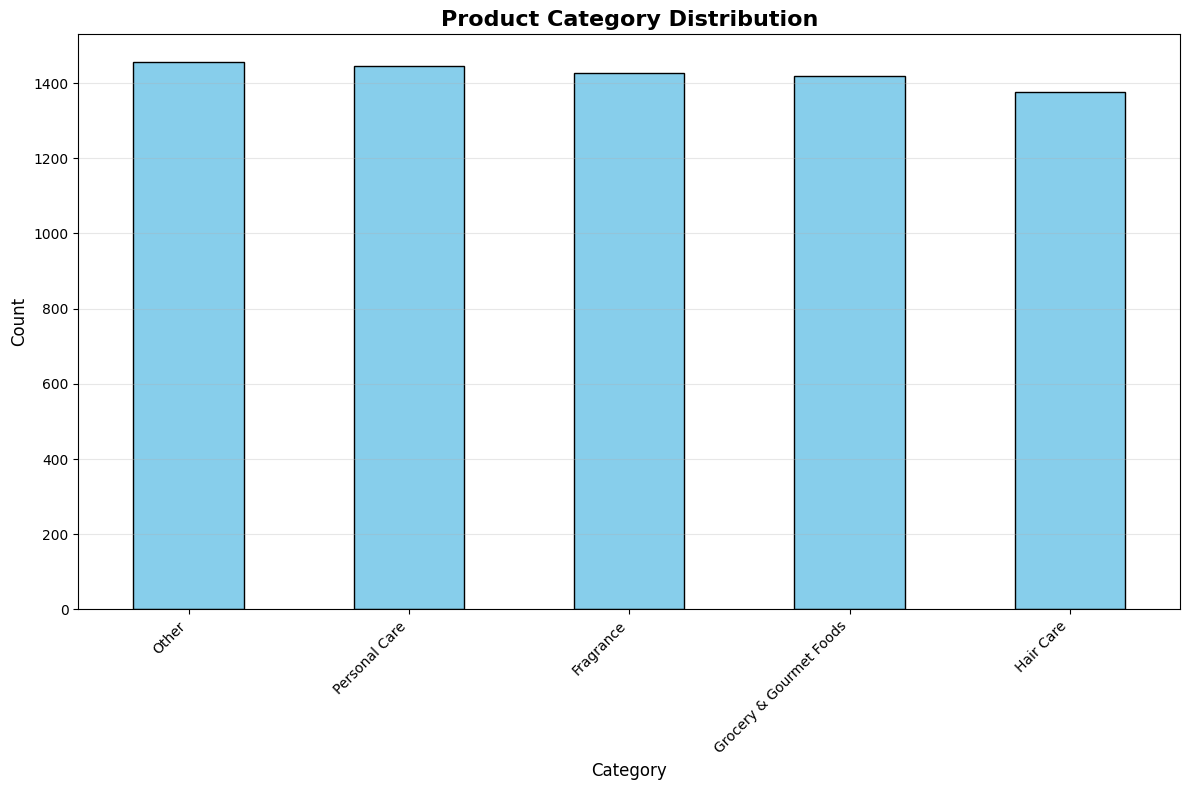

In [6]:
category_counts = df['category'].value_counts()
total_products = len(df)

print(f"Total number of products: {total_products}")
print("\nCategory Distribution:")
print("-" * 50)

for category, count in category_counts.items():
    percentage = (count / total_products) * 100
    print(f"{category}: {count} products ({percentage:.2f}%)")

print("\nSummary Statistics:")
print(f"Number of unique categories: {len(category_counts)}")
print(f"Most common category: {category_counts.index[0]} ({category_counts.iloc[0]} products)")
print(f"Least common category: {category_counts.index[-1]} ({category_counts.iloc[-1]} products)")
print(f"Imbalance ratio: {category_counts.iloc[0] / category_counts.iloc[-1]:.2f}")

plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Product Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
def clean_text(text):
    """Basic text cleaning for sentence transformers"""
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^\w\s-]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

def preprocess_text_for_embeddings(text):
    """Lightweight preprocessing for sentence transformers"""
    return clean_text(text)

test_queries = [
    "wireless earphones with noise cancellation",
    "organic shampoo for dry hair",
    "kitchen cleaning detergent"
]

print("Testing text preprocessing:")
for query in test_queries:
    processed = preprocess_text_for_embeddings(query)
    print(f"Original: '{query}'")
    print(f"Processed: '{processed}'\n")

Testing text preprocessing:
Original: 'wireless earphones with noise cancellation'
Processed: 'wireless earphones with noise cancellation'

Original: 'organic shampoo for dry hair'
Processed: 'organic shampoo for dry hair'

Original: 'kitchen cleaning detergent'
Processed: 'kitchen cleaning detergent'



In [8]:
print("Preprocessing queries for embeddings...")
df['processed_query'] = df['query'].astype(str).apply(preprocess_text_for_embeddings)

print("\nSample preprocessed data:")
for i, row in df[['query', 'processed_query', 'category']].head(3).iterrows():
    print(f"Original: '{row['query']}'")
    print(f"Processed: '{row['processed_query']}'")
    print(f"Category: {row['category']}\n")

print("Generating embeddings for all queries...")
print("This may take a few minutes depending on dataset size...")

embeddings = embed_model.encode(
    df['processed_query'].tolist(), 
    show_progress_bar=True,
    batch_size=32,
    convert_to_numpy=True
)

print(f"Generated embeddings shape: {embeddings.shape}")
print(f"Embedding dimensions: {embeddings.shape[1]}")

Preprocessing queries for embeddings...

Sample preprocessed data:
Original: 'LAFCO New York Classic Reed Diffuser, Champagne - 6 oz - Up to 3 Months Fragrance Life - Reusable, Hand Blown Glass Vessel - Natural Wood Reeds - Made in The USA'
Processed: 'lafco new york classic reed diffuser champagne - 6 oz - up to 3 months fragrance life - reusable hand blown glass vessel - natural wood reeds - made in the usa'
Category: Fragrance

Original: 'Primal Elements Wax Melt, Pineapple Rum Splash, 2.5 Ounce'
Processed: 'primal elements wax melt pineapple rum splash 2 5 ounce'
Category: Fragrance

Original: 'Wind Song Dusting Powder for Women by Prince Matchabelli, 4 Ounce'
Processed: 'wind song dusting powder for women by prince matchabelli 4 ounce'
Category: Fragrance

Generating embeddings for all queries...
This may take a few minutes depending on dataset size...


Batches: 100%|██████████| 223/223 [00:12<00:00, 17.30it/s]

Generated embeddings shape: (7123, 384)
Embedding dimensions: 384


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, 
    df['category'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['category']
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts())

Training set shape: (5698, 384)
Test set shape: (1425, 384)
Training samples: 5698
Test samples: 1425

Class distribution in training set:
category
Other                      1165
Personal Care              1157
Fragrance                  1141
Grocery & Gourmet Foods    1134
Hair Care                  1101
Name: count, dtype: int64


In [10]:
print("Training Logistic Regression with sentence transformer embeddings...")

lr_model = LogisticRegression(
    C=1.0,                    
    solver='lbfgs',           
    max_iter=1000,            
    class_weight='balanced',  
    random_state=42,
    multi_class='ovr'        
)

lr_model.fit(X_train, y_train)

print("Model training completed!")
print(f"Number of classes: {len(lr_model.classes_)}")
print(f"Classes: {list(lr_model.classes_)}")

c:\Users\Nikhil\Downloads\New folder\myvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Logistic Regression with sentence transformer embeddings...
Model training completed!
Number of classes: 5
Classes: ['Fragrance', 'Grocery & Gourmet Foods', 'Hair Care', 'Other', 'Personal Care']


In [11]:
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = lr_model.score(X_train, y_train)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=lr_model.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
print(cm)

Training Accuracy: 0.8884
Test Accuracy: 0.8772

Detailed Classification Report:
                         precision    recall  f1-score   support

              Fragrance       0.89      0.93      0.91       285
Grocery & Gourmet Foods       0.91      0.94      0.93       284
              Hair Care       0.94      0.84      0.89       275
                  Other       0.84      0.89      0.86       292
          Personal Care       0.81      0.79      0.80       289

               accuracy                           0.88      1425
              macro avg       0.88      0.88      0.88      1425
           weighted avg       0.88      0.88      0.88      1425


Confusion Matrix:
[[266   5   0   4  10]
 [  4 267   2   8   3]
 [  1   5 231  13  25]
 [  5  10   4 259  14]
 [ 24   5   8  25 227]]


In [12]:
print("Saving models...")
    
joblib.dump(lr_model, LR_MODEL_PATH)
print(f"Saved logistic regression model to: {LR_MODEL_PATH}")

print(f"\nModel files saved in: {MODEL_DIR}/")
print(f"Files created:")
print(f"- {LR_MODEL_PATH}")

Saving models...
Saved logistic regression model to: models\lr_embeddings.pkl

Model files saved in: models/
Files created:
- models\lr_embeddings.pkl


In [13]:
def predict_with_confidence(query: str) -> tuple:
    processed_query = preprocess_text_for_embeddings(query)
    query_embedding = embed_model.encode([processed_query])
    prediction = lr_model.predict(query_embedding)[0]
    probabilities = lr_model.predict_proba(query_embedding)[0]
    confidence = max(probabilities)
    top_indices = np.argsort(probabilities)[-3:][::-1]
    top_predictions = [(lr_model.classes_[i], probabilities[i]) for i in top_indices]
    return prediction, confidence, top_predictions

print("Prediction functions created successfully!")

Prediction functions created successfully!


In [14]:
# Test with sample queries
test_queries = [
    "moisturizing body wash",
    "wireless bluetooth headphones", 
    "organic shampoo for dry hair",
    "kitchen floor cleaning detergent",
    "lavender scented candle",
    "vitamin C face serum",
    "dish washing liquid soap",
    "coconut oil hair mask",
    "smartphone screen cleaner",
    "herbal tea for relaxation"
]

print("Testing predictions with sentence transformer embeddings:")
print("=" * 80)

for query in test_queries:
    try:
        prediction, confidence, top_predictions = predict_with_confidence(query)
        
        print(f"Query: '{query}'")
        print(f"Predicted Category: {prediction} (confidence: {confidence:.3f})")
        print("Top 3 predictions:")
        for i, (cat, prob) in enumerate(top_predictions, 1):
            print(f"  {i}. {cat}: {prob:.3f}")
        print("-" * 80)
        
    except Exception as e:
        print(f"Error predicting for '{query}': {e}")
        print("-" * 80)

Testing predictions with sentence transformer embeddings:
Query: 'moisturizing body wash'
Predicted Category: Personal Care (confidence: 0.618)
Top 3 predictions:
  1. Personal Care: 0.618
  2. Hair Care: 0.302
  3. Fragrance: 0.042
--------------------------------------------------------------------------------
Query: 'wireless bluetooth headphones'
Predicted Category: Other (confidence: 0.649)
Top 3 predictions:
  1. Other: 0.649
  2. Hair Care: 0.323
  3. Grocery & Gourmet Foods: 0.014
--------------------------------------------------------------------------------
Query: 'organic shampoo for dry hair'
Predicted Category: Hair Care (confidence: 0.882)
Top 3 predictions:
  1. Hair Care: 0.882
  2. Fragrance: 0.062
  3. Other: 0.026
--------------------------------------------------------------------------------
Query: 'kitchen floor cleaning detergent'
Predicted Category: Fragrance (confidence: 0.428)
Top 3 predictions:
  1. Fragrance: 0.428
  2. Other: 0.248
  3. Personal Care: 0.24

In [16]:
print("MODEL PERFORMANCE SUMMARY")
print("=" * 60)

print(f"Model Type: Sentence Transformer + Logistic Regression")
print(f"Embedding Model: all-MiniLM-L6-v2")
print(f"Embedding Dimensions: {embed_model.get_sentence_embedding_dimension()}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Number of Categories: {len(lr_model.classes_)}")
print(f"Categories: {list(lr_model.classes_)}")
print(f"Total Training Samples: {len(X_train)}")
print(f"Total Test Samples: {len(X_test)}")

print(f"\nModel File: {LR_MODEL_PATH}")

print("\nTraining and evaluation completed successfully!")

MODEL PERFORMANCE SUMMARY
Model Type: Sentence Transformer + Logistic Regression
Embedding Model: all-MiniLM-L6-v2
Embedding Dimensions: 384
Training Accuracy: 0.8884
Test Accuracy: 0.8772
Number of Categories: 5
Categories: ['Fragrance', 'Grocery & Gourmet Foods', 'Hair Care', 'Other', 'Personal Care']
Total Training Samples: 5698
Total Test Samples: 1425

Model File: models\lr_embeddings.pkl

Training and evaluation completed successfully!
